In [1]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
sys.path.insert(1, oj(sys.path[0], '..', 'vision_fit'))  # insert parent path
sys.path.insert(1, oj(sys.path[0], '..', 'vision_analyze'))  # insert parent path

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import math

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%load_ext autoreload
%autoreload 2

import statsmodels.tsa.api as smt
import traceback

import style
cb = '#008fd5'
cr = '#fc4f30'

In [2]:
style.set_style()

# generate some arma data

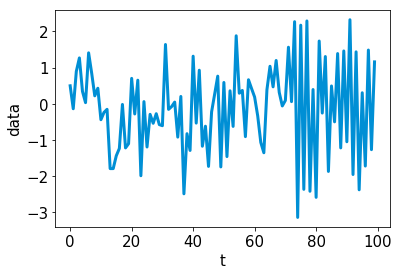

In [78]:
np.random.seed(42)
ar = [1, 0.75, -0.25] # first index is for zero lag
ma = [1, 0.75, 0.25] # first index is for zero lag

n = 100
sample = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, sigma=1)

plt.plot(sample, color=cb)
plt.xlabel('t')
plt.ylabel('data')
plt.show()

# fit and inspect an individual model

In [93]:
p, q = 3, 3
m = smt.ARMA(sample, order=(p, q))
results = m.fit(transparams=False)

In [103]:
preds = pred_all(sample, results)

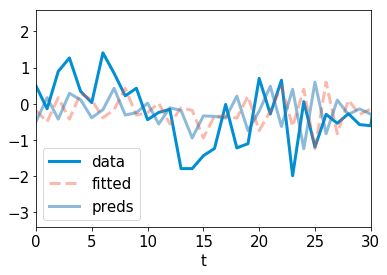

In [105]:
plt.plot(sample, color=cb, label='data')
# plt.plot(results.fittedvalues, color=cr, linestyle='--', alpha=0.4, label='fitted')
plt.plot(preds, label='preds')
plt.xlabel('t')
plt.xlim((0, 30))
plt.legend()

# try to select given p, q based on complexity measure
**no need for test set since we know the gt params**

100%|██████████| 2/2 [00:18<00:00, 11.18s/it]


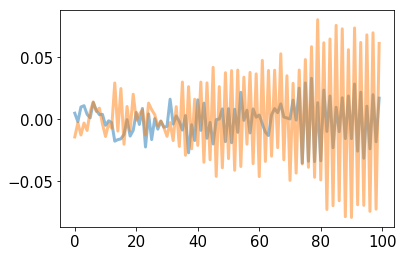

In [130]:
def pred_all(sample, mod):
    '''Doesn't return first time-step, so preds are one shorter than sample size
    '''
    preds = []
    for i in range(sample.size): #sample.size):
        preds.append(mod.predict(start=i, end=i + 1)[-1])
    return np.array(preds)[:-1]

def arma_order_select_ic(sample, max_ar=5, max_ma=5, trend='c', model_kw={}, fit_kw={}):
    '''Try a bunch and see which is best
    '''
    
    results = np.zeros((3, max_ar, max_ma))
    ar_range = np.arange(max_ar) + 1
    ma_range = np.arange(max_ma) + 1
    for ar in ar_range:
        for ma in ma_range:
            mod = smt.ARMA(sample, order=(ar, ma), **model_kw).fit(disp=0, trend=trend, **fit_kw)
            if mod is None:
                results[:, ar - 1, ma - 1] = np.nan
                continue
            ll = mod.llf
            
            for i, criteria in enumerate(['aic', 'bic']):
                results[i, ar - 1, ma - 1] = getattr(mod, criteria)
                
#             preds = pred_all(sample, mod)
            preds = mod.fittedvalues
            pls = np.mean(np.square(preds - sample))
            results[2, ar - 1, ma - 1] = pls
            
                
    dfs = [pd.DataFrame(res, columns=ma_range, index=ar_range) for res in results]
    res = dict(zip(['aic', 'bic'] + ['pls'], dfs))

    # add the minimums to the results dict
    min_res = {}
    for i, k in enumerate(res.keys()):
        result = res[k]
        mins = [x + 1 for x in np.where(result.min().min() == result)] # add 1 because we don't pass 0
        min_res.update({k + '_min_order' : (mins[0][0], mins[1][0])})
    res.update(min_res)
    res['pred'] = mod.fittedvalues

    return res

ar = [1, 0.75, -0.25] # first index is for zero lag
ma = [1, 0.65, 0.35] # first index is for zero lag
# ar = [1]
# ma = [1]
n = 100
sigma = 0.01
start_params = [0] * (len(ar) + len(ma) + 3) # this is very strange

np.random.seed(42)
gt = (len(ar) - 1, len(ma) - 1) # p, q
ics = ['bic', 'aic', 'pls']
correct_arr = {ic: [] for ic in ics}
for i in tqdm(range(2)):
    try:
        sample = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, sigma=0.01) #0.01)
        plt.plot(sample)
        results = arma_order_select_ic(sample, max_ar=4, max_ma=4, fit_kw={'transparams': False, 'start_params': start_params})
        for ic in ics:
            correct_arr[ic].append(1 * (results[ic + '_min_order'] == gt))
    except:
        print(traceback.format_exc())

In [132]:
df_correct = pd.DataFrame.from_dict(correct_arr)

In [133]:
results

{'aic':             1           2           3           4
 1 -579.856746 -407.057775 -433.760027 -631.126512
 2 -346.147121 -355.196809 -356.840418 -509.561776
 3 -344.147121 -342.147121 -340.147121 -338.147121
 4 -342.147121 -340.147121 -338.147121 -336.147121,
 'bic':             1           2           3           4
 1 -569.436066 -394.031924 -418.129006 -612.890321
 2 -333.121270 -339.565788 -338.604227 -488.720415
 3 -328.516100 -323.910930 -319.305760 -314.700589
 4 -323.910930 -319.305760 -314.700589 -310.095419,
 'pls':           1         2         3         4
 1  0.000165  0.000904  0.000678  0.000093
 2  0.001663  0.001489  0.001435  0.000304
 3  0.001663  0.001663  0.001663  0.001663
 4  0.001663  0.001663  0.001663  0.001663,
 'aic_min_order': (1, 4),
 'bic_min_order': (1, 4),
 'pls_min_order': (1, 4),
 'pred': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0

In [129]:
# ar is row, max is col
results['bic']

0    0
1    0
Name: bic, dtype: int64

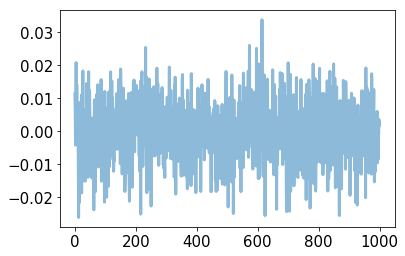

In [131]:
plt.plot(sample)    